# Set up

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import bbknn
import sctk as sk

In [9]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200)

scanpy==1.8.2 anndata==0.8.0 umap==0.4.6 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.1 python-igraph==0.10.2 louvain==0.7.0 pynndescent==0.5.7


# Read and log-norm data

In [16]:
adata=sc.read_h5ad('/nfs/team205/heart/anndata_objects/AX-AVN_vCM-aCM_post-scVI_with_UMAP_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 39592 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', '_scvi_batch', '_scvi_labels', 'n_counts', 'leiden'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_id'
    uns: '_scvi', 'cell_state_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [17]:
print(adata.X.data[:5])
print(adata.var[:5])

[0.4275917 0.4275917 0.4275917 0.4275917 0.4275917]
                     gene_name_scRNA-0 gene_name_snRNA-1          gene_id
gene_name_multiome-2                                                     
MIR1302-2HG                MIR1302-2HG       MIR1302-2HG  ENSG00000243485
FAM138A                        FAM138A           FAM138A  ENSG00000237613
OR4F5                            OR4F5             OR4F5  ENSG00000186092
AL627309.1                  AL627309.1        AL627309.1  ENSG00000238009
AL627309.3                  AL627309.3        AL627309.3  ENSG00000239945


In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Plot data

In [19]:
# read in suspect cells index
suspect_index = pd.read_csv('/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/Purkinje/suspect_cell_index.csv',)['barcode']

adata.obs['AX_Purkinje-like'] = 'No'
adata.obs.loc[suspect_index,'AX_Purkinje-like'] = 'Yes'

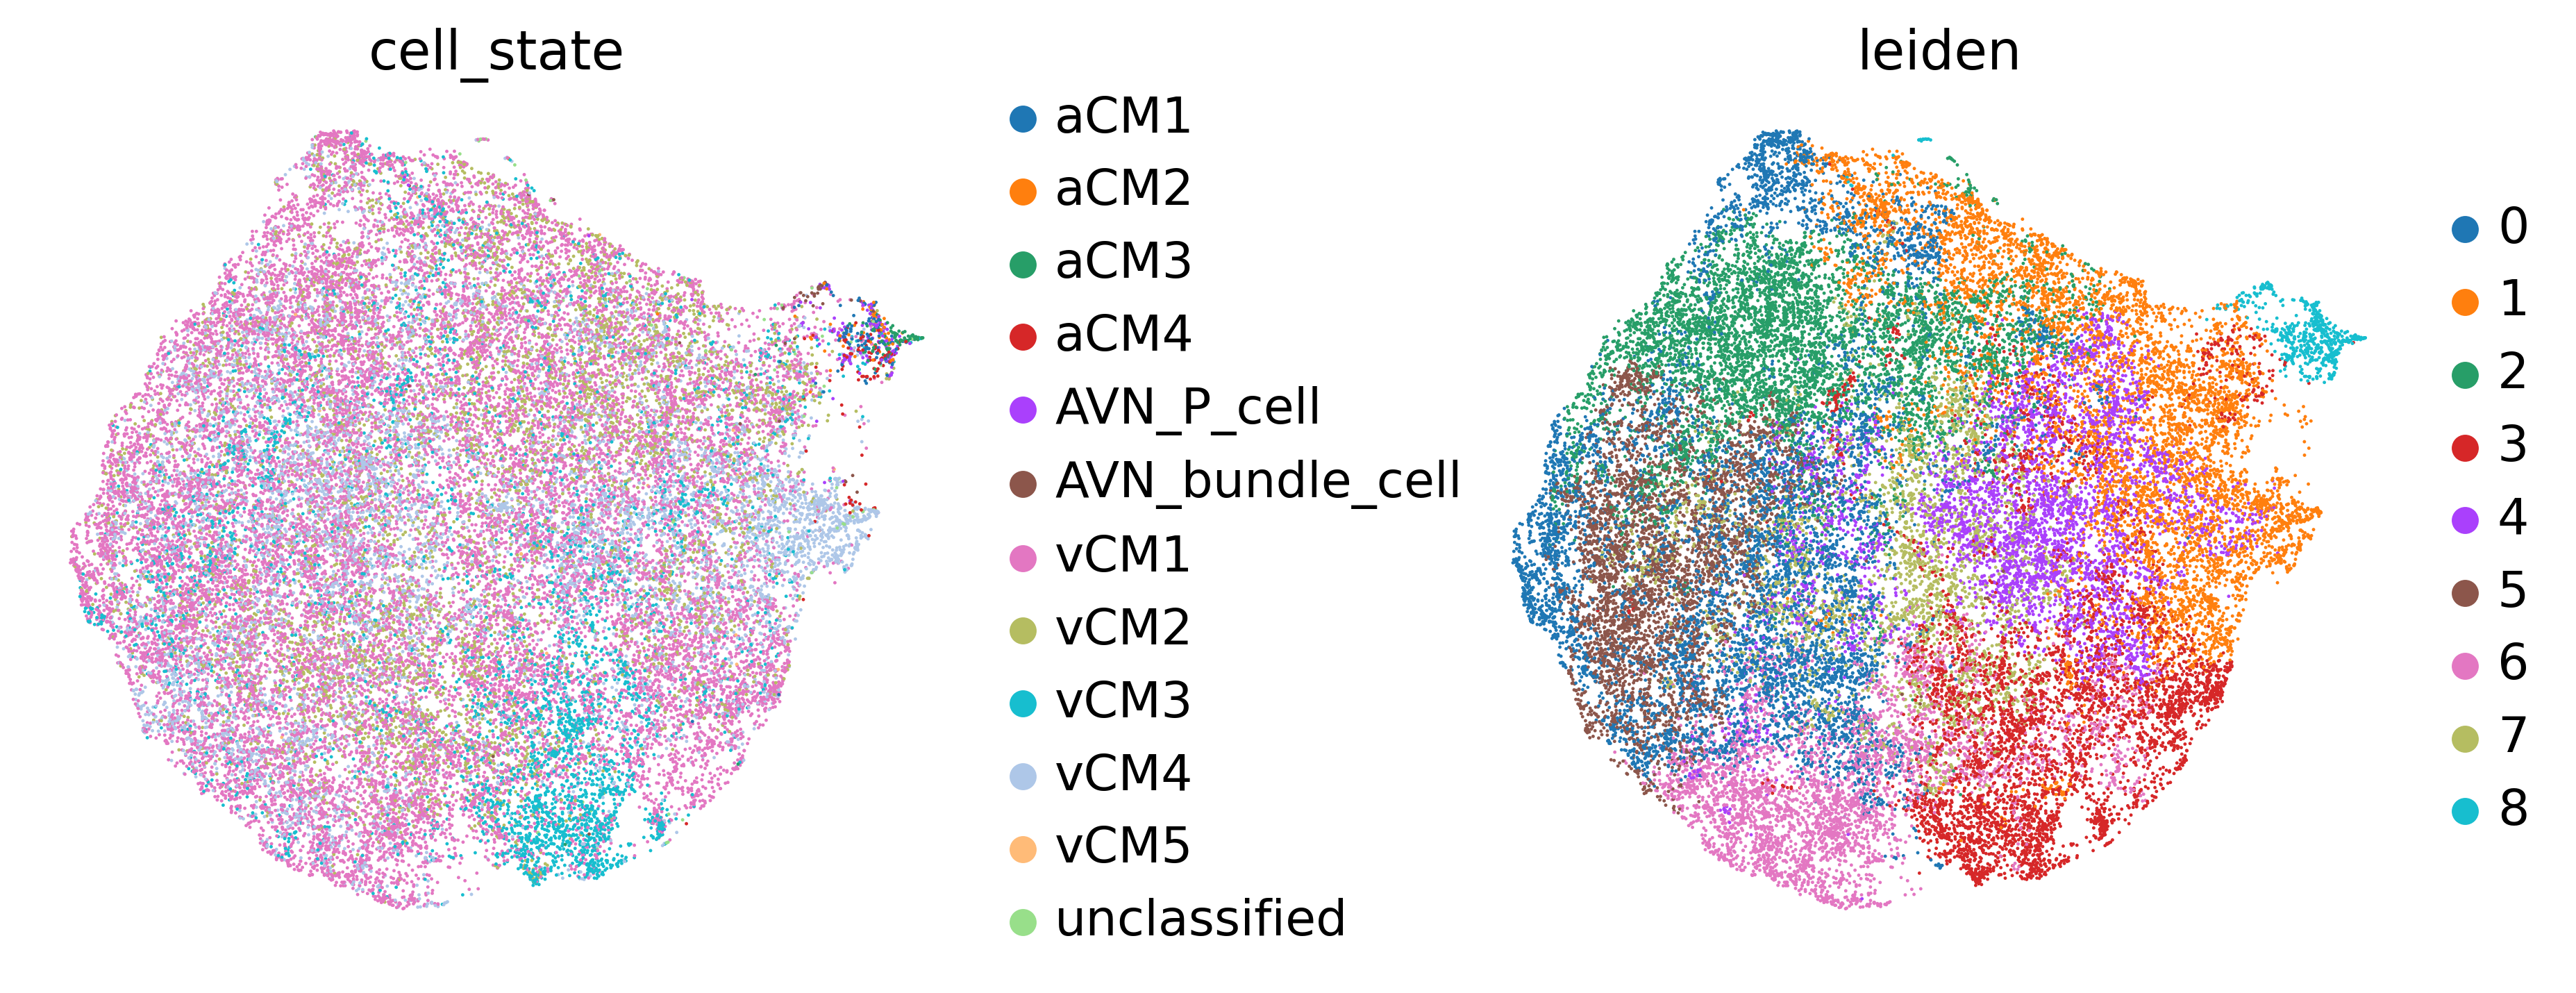

In [20]:
# Plot re-clustered
sc.pl.umap(adata, color=['cell_state','leiden'], frameon = False, wspace=0.4)

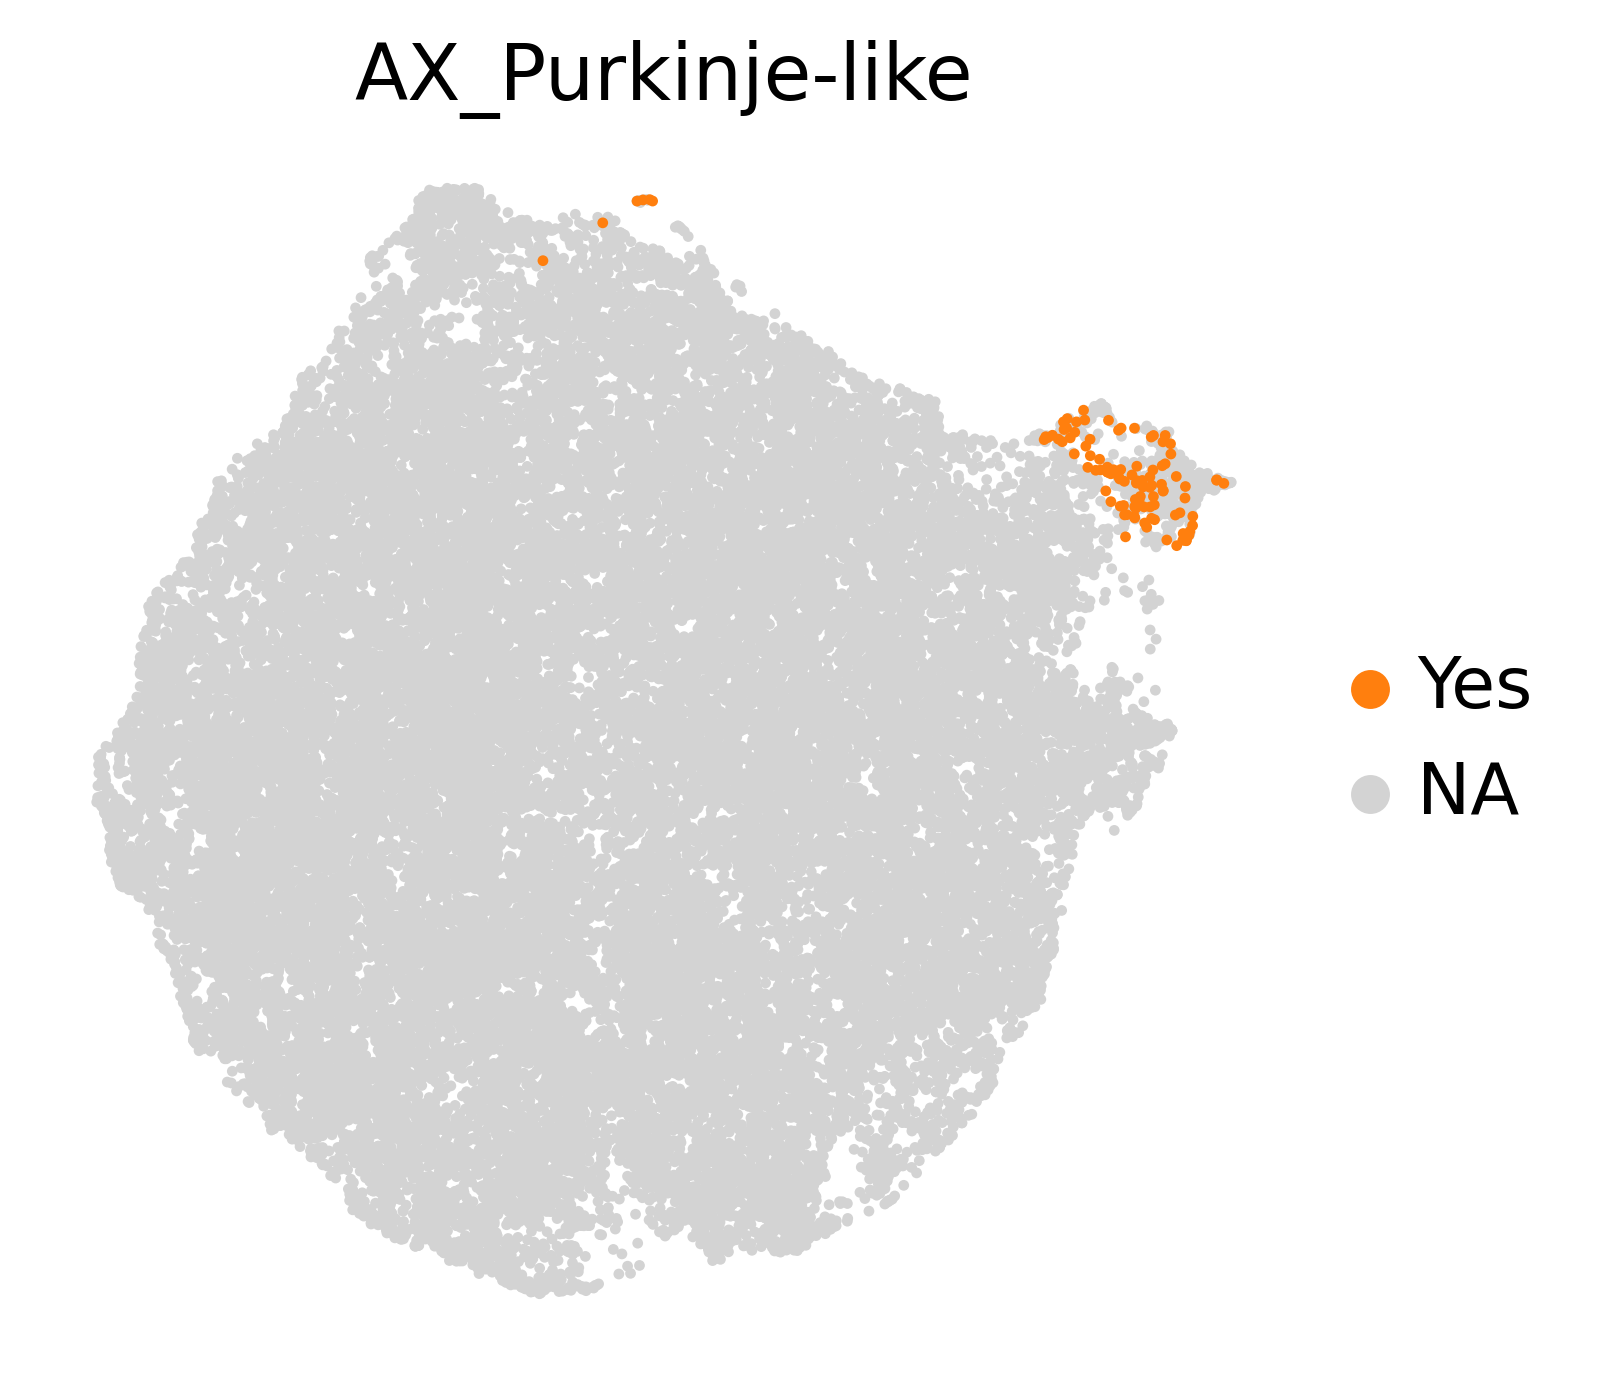

In [15]:
# Plot re-clustered
sc.pl.umap(adata, color=['AX_Purkinje-like'], groups='Yes', size=15, frameon = False, wspace=0.4)

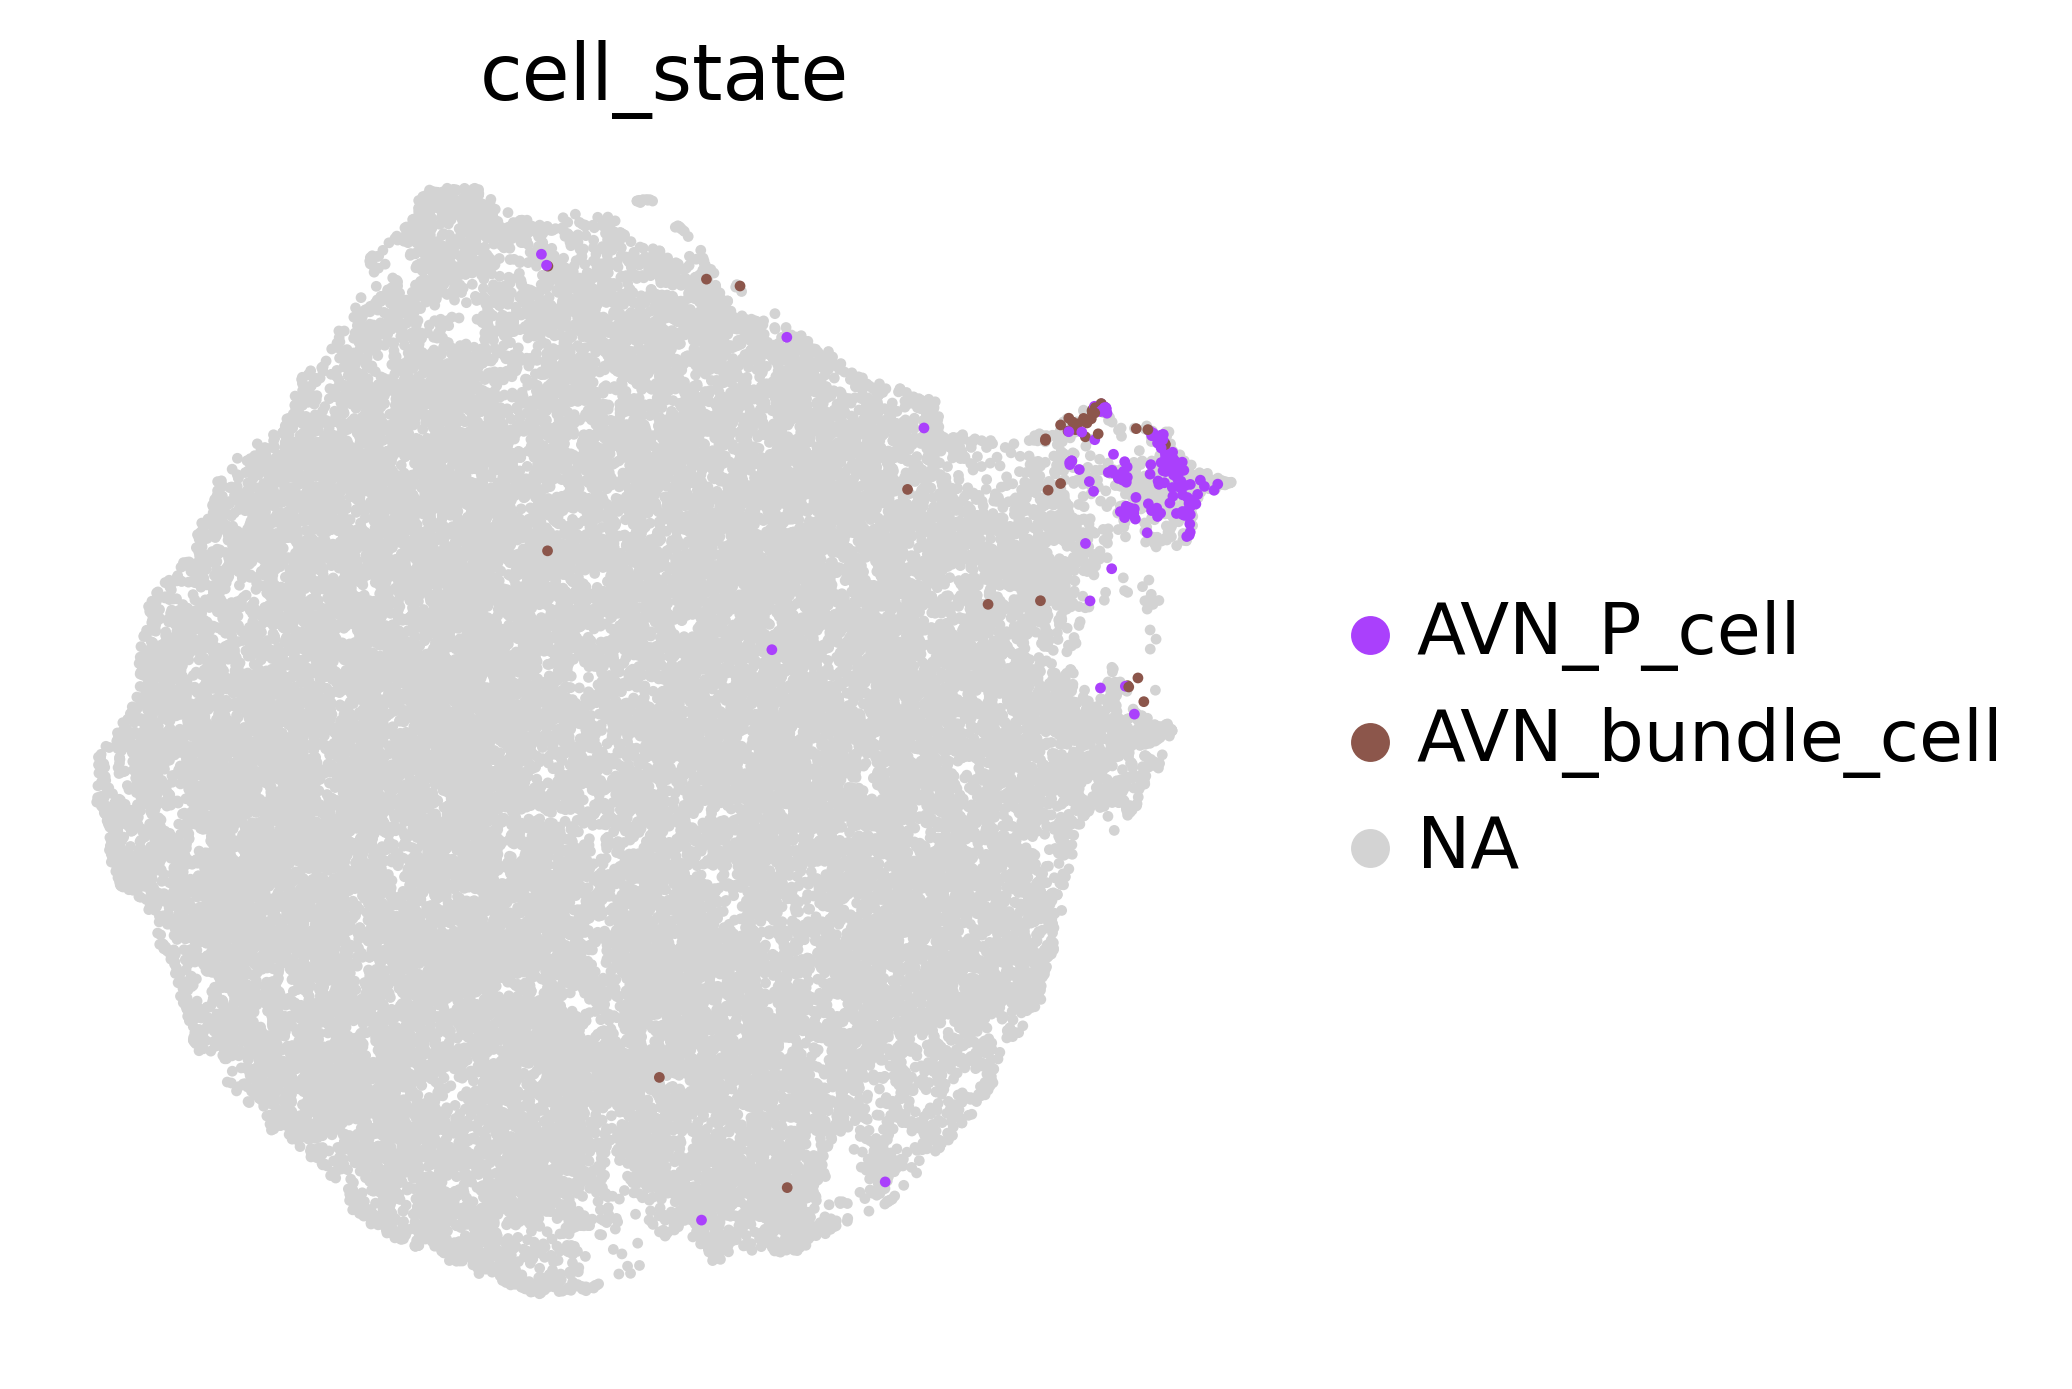

In [21]:
sc.pl.umap(adata, color=['cell_state'], frameon = False, wspace=0.4, size=15,
          groups=['AVN_P_cell','AVN_bundle_cell'])

In [22]:
# combine cell_state and region labels
adata.obs['cell_state_region'] = adata.obs['cell_state'].astype('str') + ' (' + adata.obs['region'].astype('str') + ')'

# read in suspect cells index
suspect_index = pd.read_csv('/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/Purkinje/suspect_cell_index.csv',)['barcode']
adata.obs.loc[suspect_index,'cell_state_region'] = 'Purkinje-like_cell (AX)'

adata.obs['cell_state_to_show'] = adata.obs['cell_state_region'].astype('str')
adata.obs.replace({'cell_state_to_show':{
    'aCM1 (AVN)': 'aCM (AVN)',
     'aCM2 (AVN)': 'aCM (AVN)',
     'aCM3 (AVN)': 'aCM (AVN)',
     'aCM4 (AVN)': 'aCM (AVN)',
    'vCM1 (AVN)': 'vCM (AVN)',
     'vCM1 (AX)': 'vCM (AX)',
     'vCM2 (AVN)': 'vCM (AVN)',
     'vCM2 (AX)': 'vCM (AX)',
     'vCM3 (AVN)': 'vCM (AVN)',
     'vCM3 (AX)': 'vCM (AX)',
     'vCM4 (AVN)': 'vCM (AVN)',
     'vCM4 (AX)': 'vCM (AX)',
     'vCM5 (AX)': 'vCM (AX)'
}}, inplace=True)

set(adata.obs['cell_state_to_show'])

{'AVN_P_cell (AVN)',
 'AVN_bundle_cell (AVN)',
 'Purkinje-like_cell (AX)',
 'aCM (AVN)',
 'unclassified (AVN)',
 'unclassified (AX)',
 'vCM (AVN)',
 'vCM (AX)'}

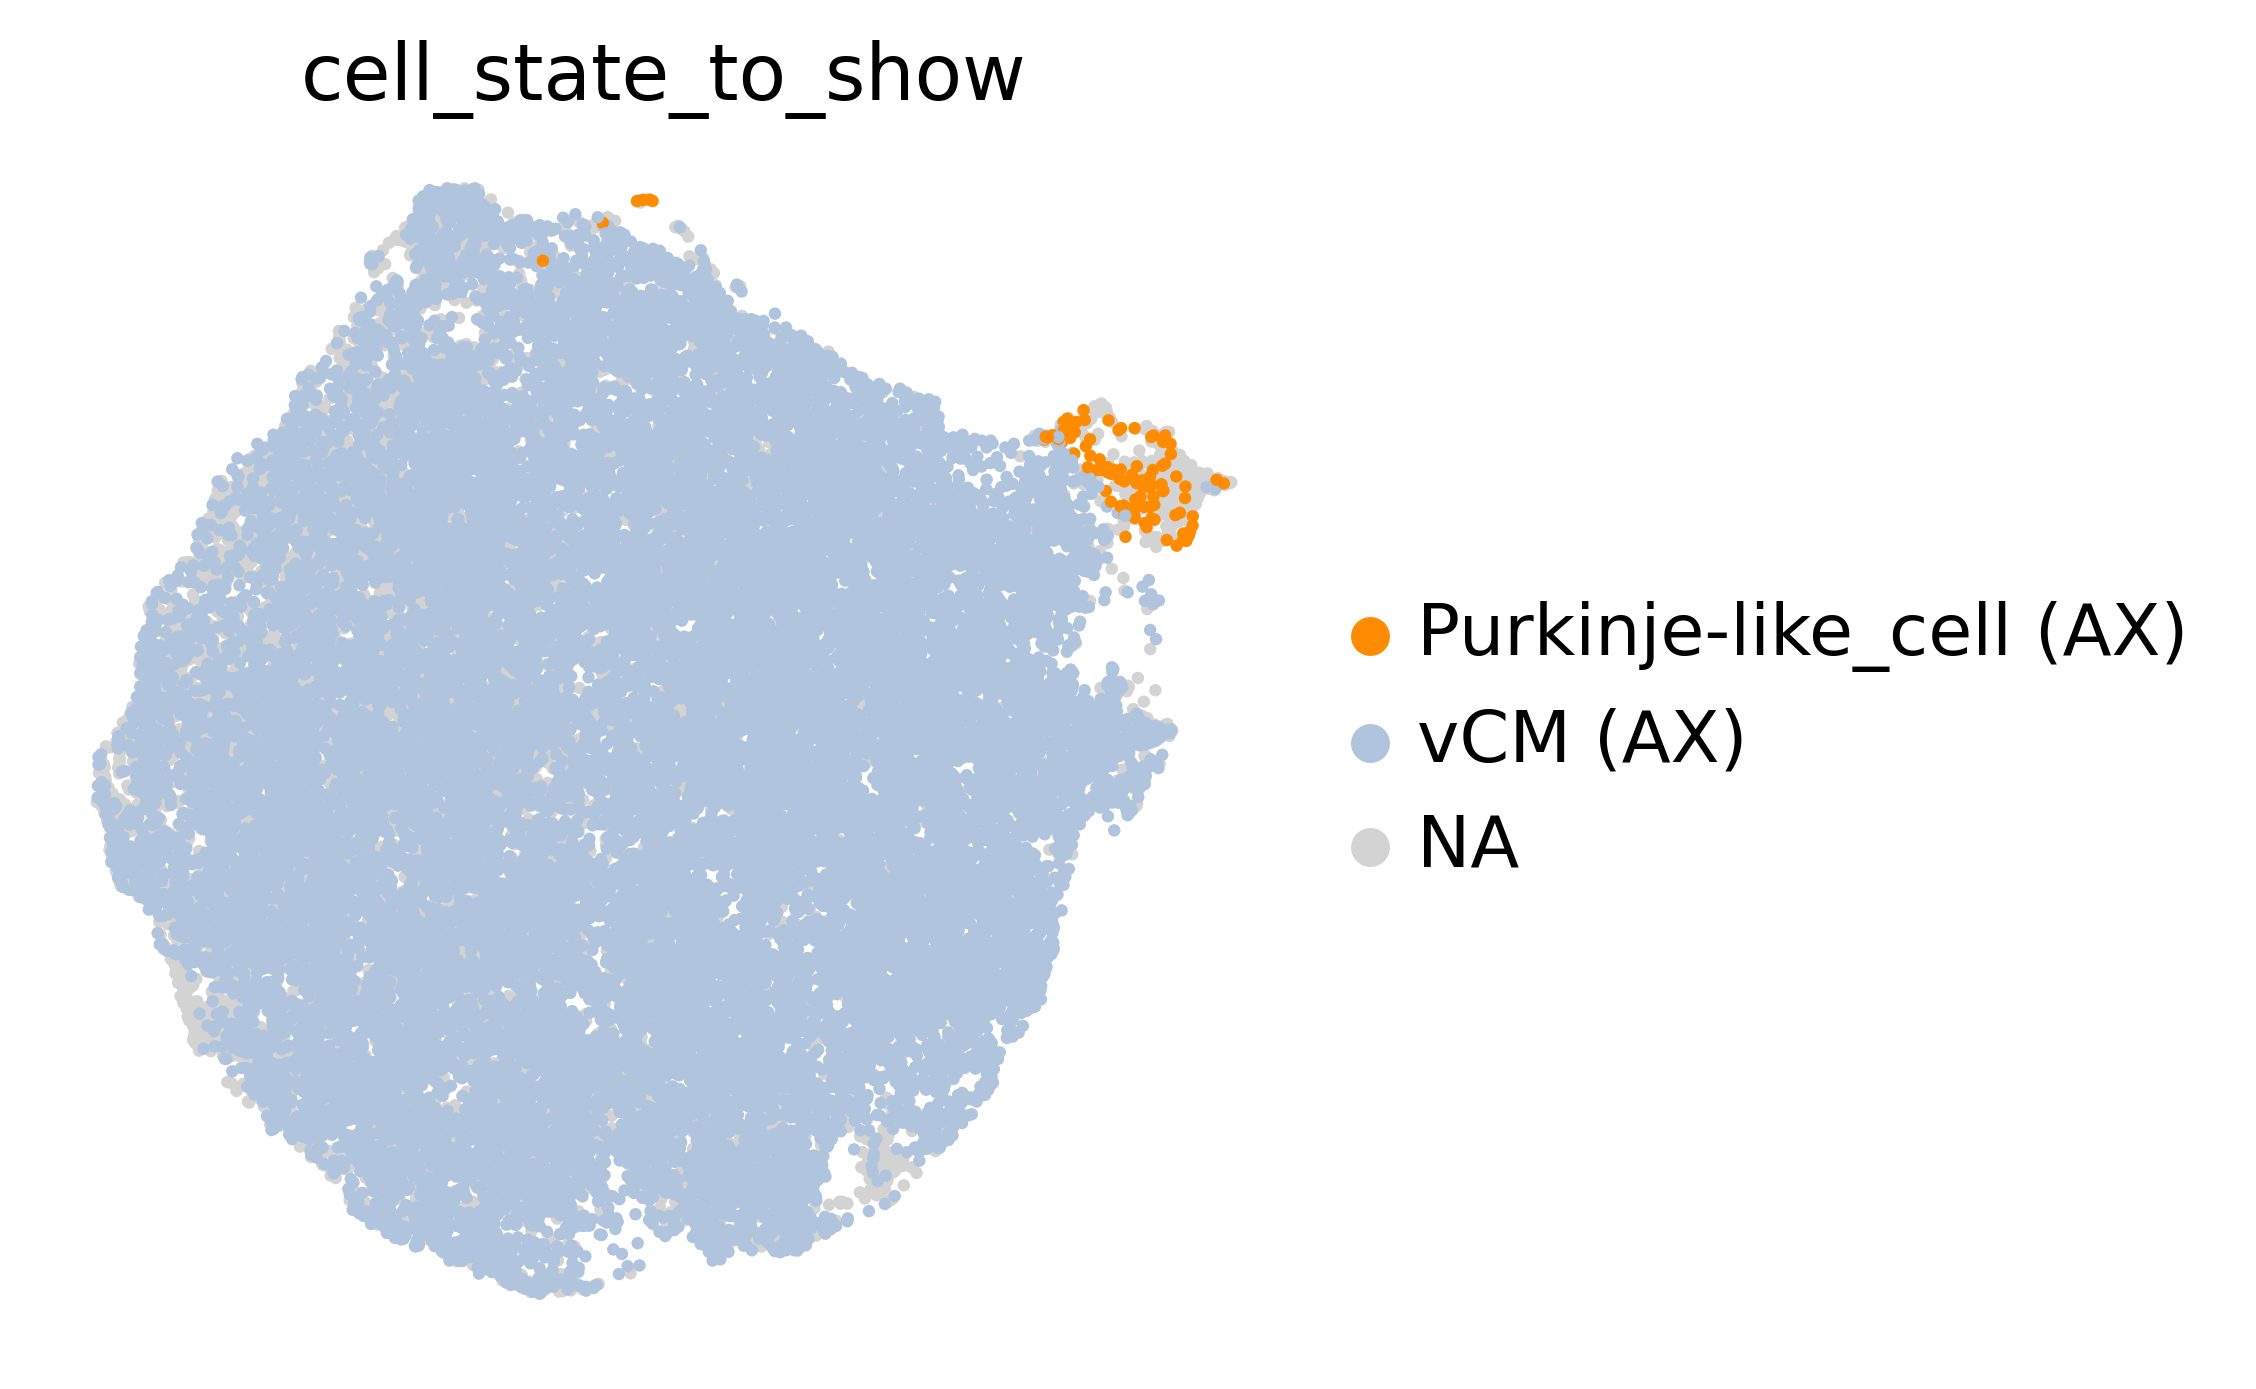

In [30]:
# sc.pl.umap(adata, color=['cell_state_to_show'], frameon = False, wspace=0.4, size=10, show=False)
adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('AVN_P_cell (AVN)')]='dodgerblue'
adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('AVN_bundle_cell (AVN)')]='skyblue'
adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('Purkinje-like_cell (AX)')]='darkorange'
adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('vCM (AX)')]='lightsteelblue'

sc.pl.umap(adata, color=['cell_state_to_show'], frameon = False, wspace=0.4, size=20,
          groups=[
                 'Purkinje-like_cell (AX)',
                 'vCM (AX)'],
          save='_AX-Purkinje.pdf')

In [37]:
adata.obs['cell_state_to_show'].cat.reorder_categories([
    'Purkinje-like_cell (AX)','AVN_P_cell (AVN)', 'AVN_bundle_cell (AVN)', 
       'aCM (AVN)', 'unclassified (AVN)', 'unclassified (AX)', 'vCM (AVN)',
       'vCM (AX)'
],inplace=True)

<AxesSubplot:title={'center':'cell_state_to_show'}, xlabel='UMAP1', ylabel='UMAP2'>

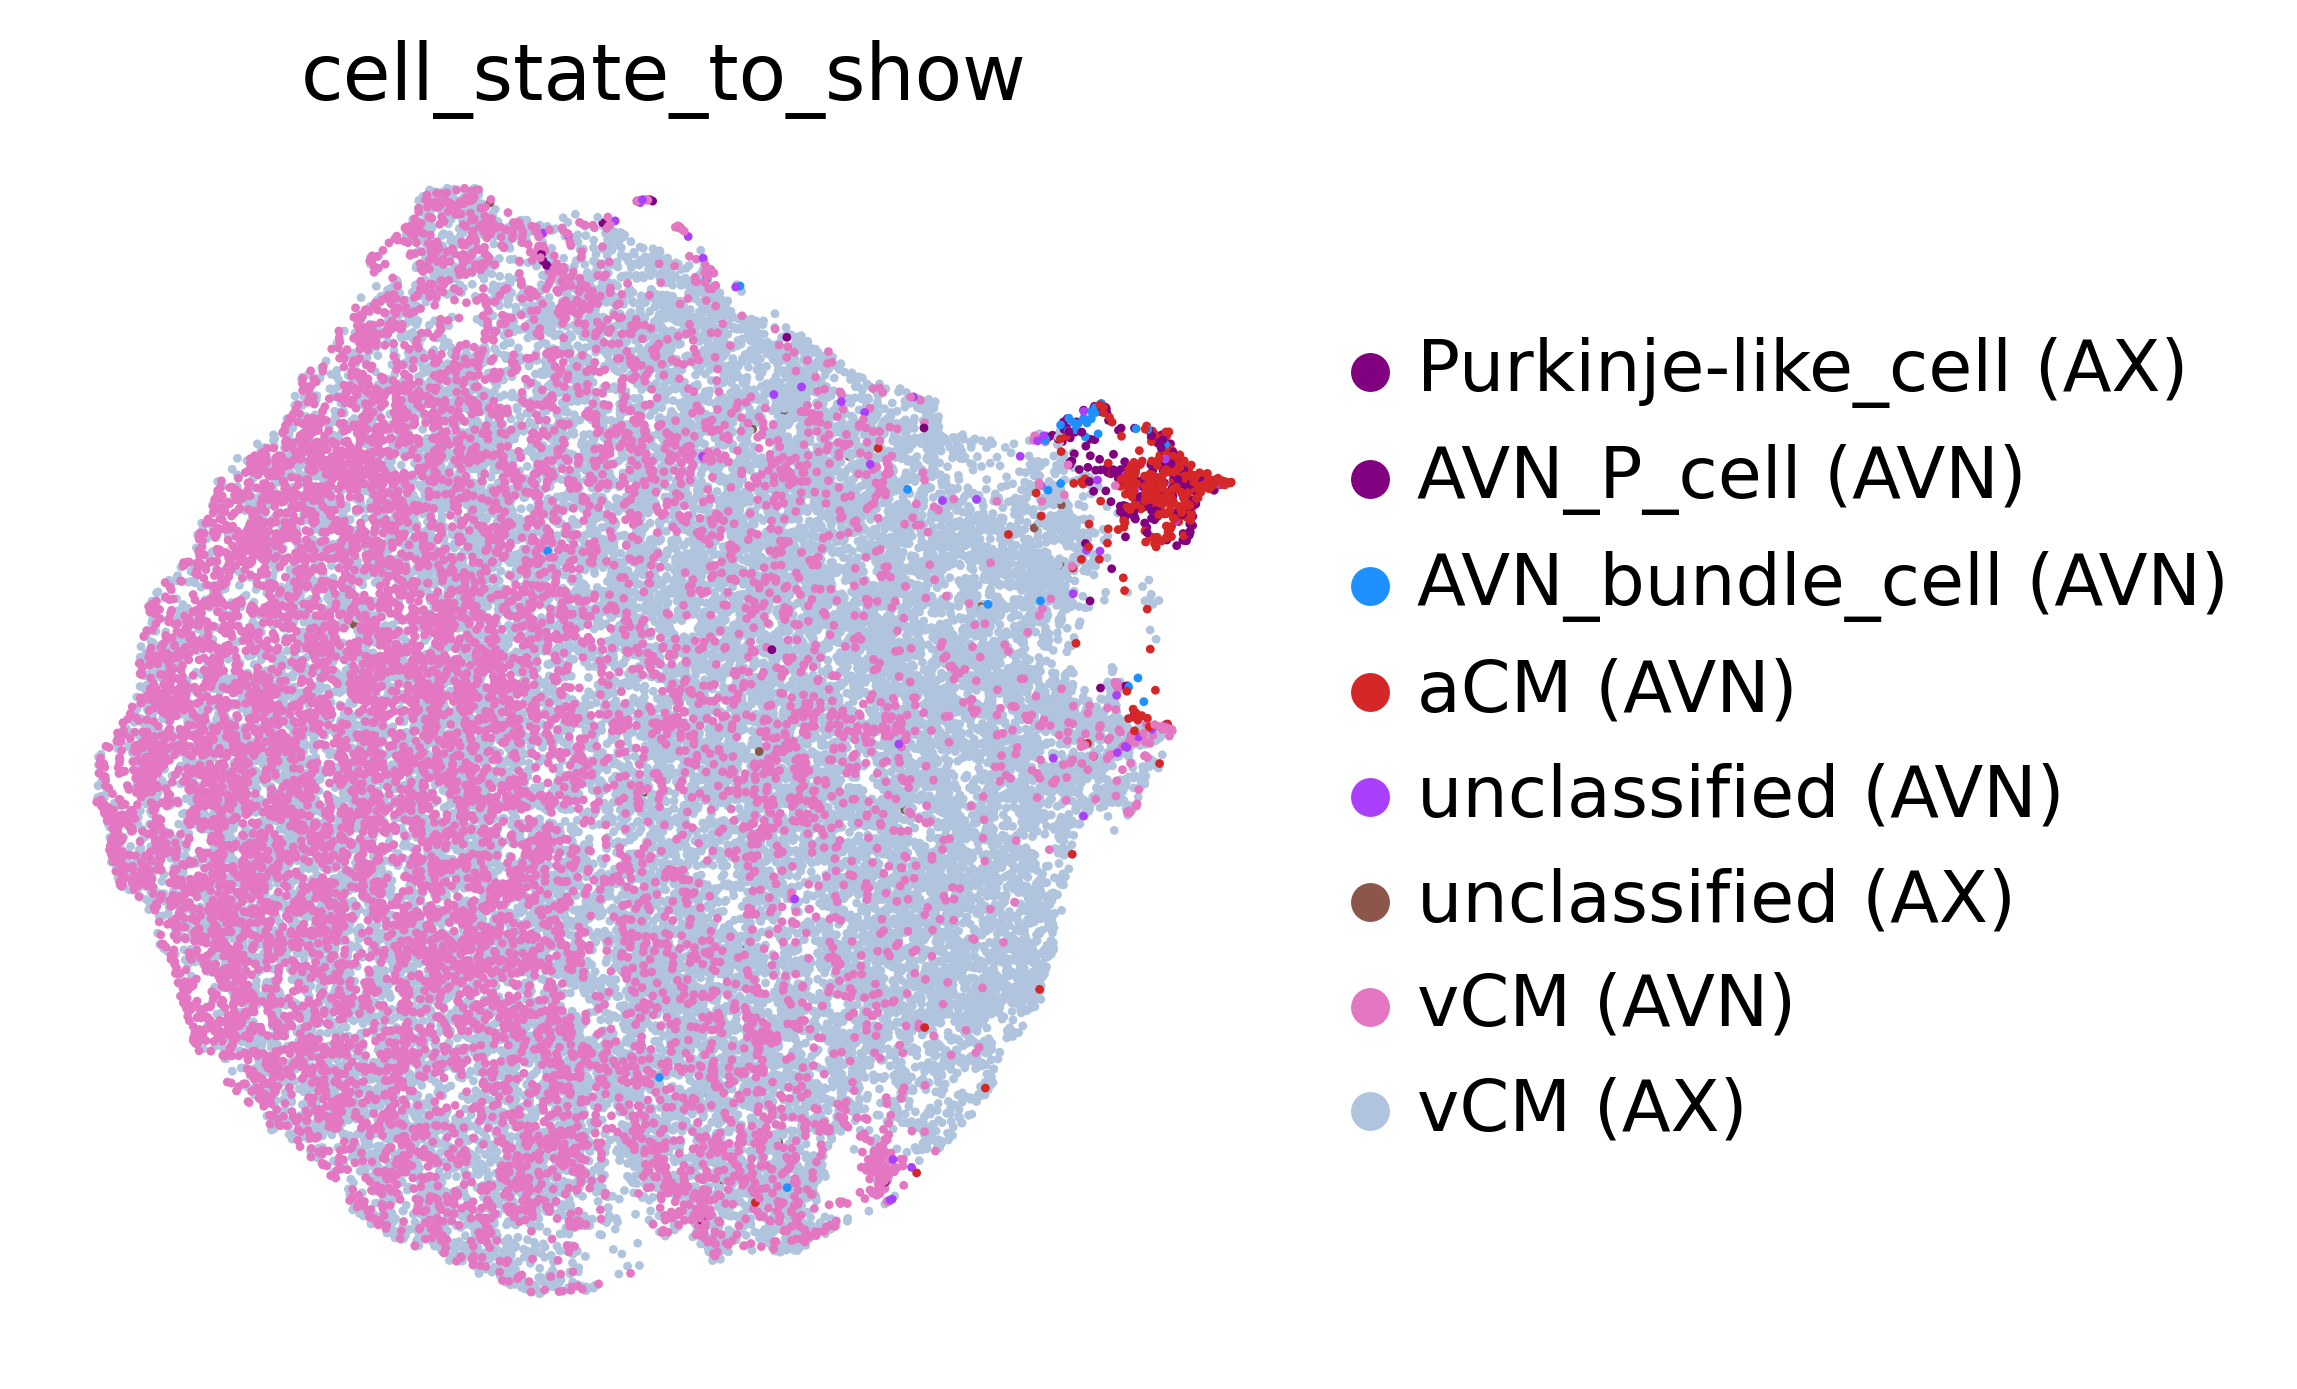

In [38]:
sc.pl.umap(adata, color=['cell_state_to_show'], frameon = False, wspace=0.4, size=10, show=False)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(22,5))
dotsize=10

sc.pl.umap(adata, color=['leiden'], frameon = False, size=dotsize,
          show=False, ax=axs[0])

reg='AVN'
sc.pl.umap(adata, color=['region'], groups=reg, frameon=False, size=dotsize,legend_loc=None,
           title=reg, show=False, ax=axs[1])
reg='AX'
sc.pl.umap(adata, color=['region'], groups=reg, frameon=False, size=dotsize,legend_loc=None,
           title=reg, show=False, ax=axs[2])

adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('AVN_P_cell (AVN)')]='#279e68'
adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('AVN_bundle_cell (AVN)')]='dodgerblue'
adata.uns["cell_state_to_show_colors"][list(adata.obs['cell_state_to_show'].cat.categories).index('Purkinje-like_cell (AX)')]='darkorange'
sc.pl.umap(adata, color=['cell_state_to_show'], frameon = False, wspace=0.4, size=30,
          groups=[
                 'AVN_P_cell (AVN)',
                 'AVN_bundle_cell (AVN)',
          'Purkinje-like_cell (AX)'], show=False, ax=axs[3])

plt.tight_layout()
fig.savefig(f'./figures/umap_AVN-AX.pdf')

In [46]:
adata.uns["leiden_colors"]

array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf'], dtype=object)

[]

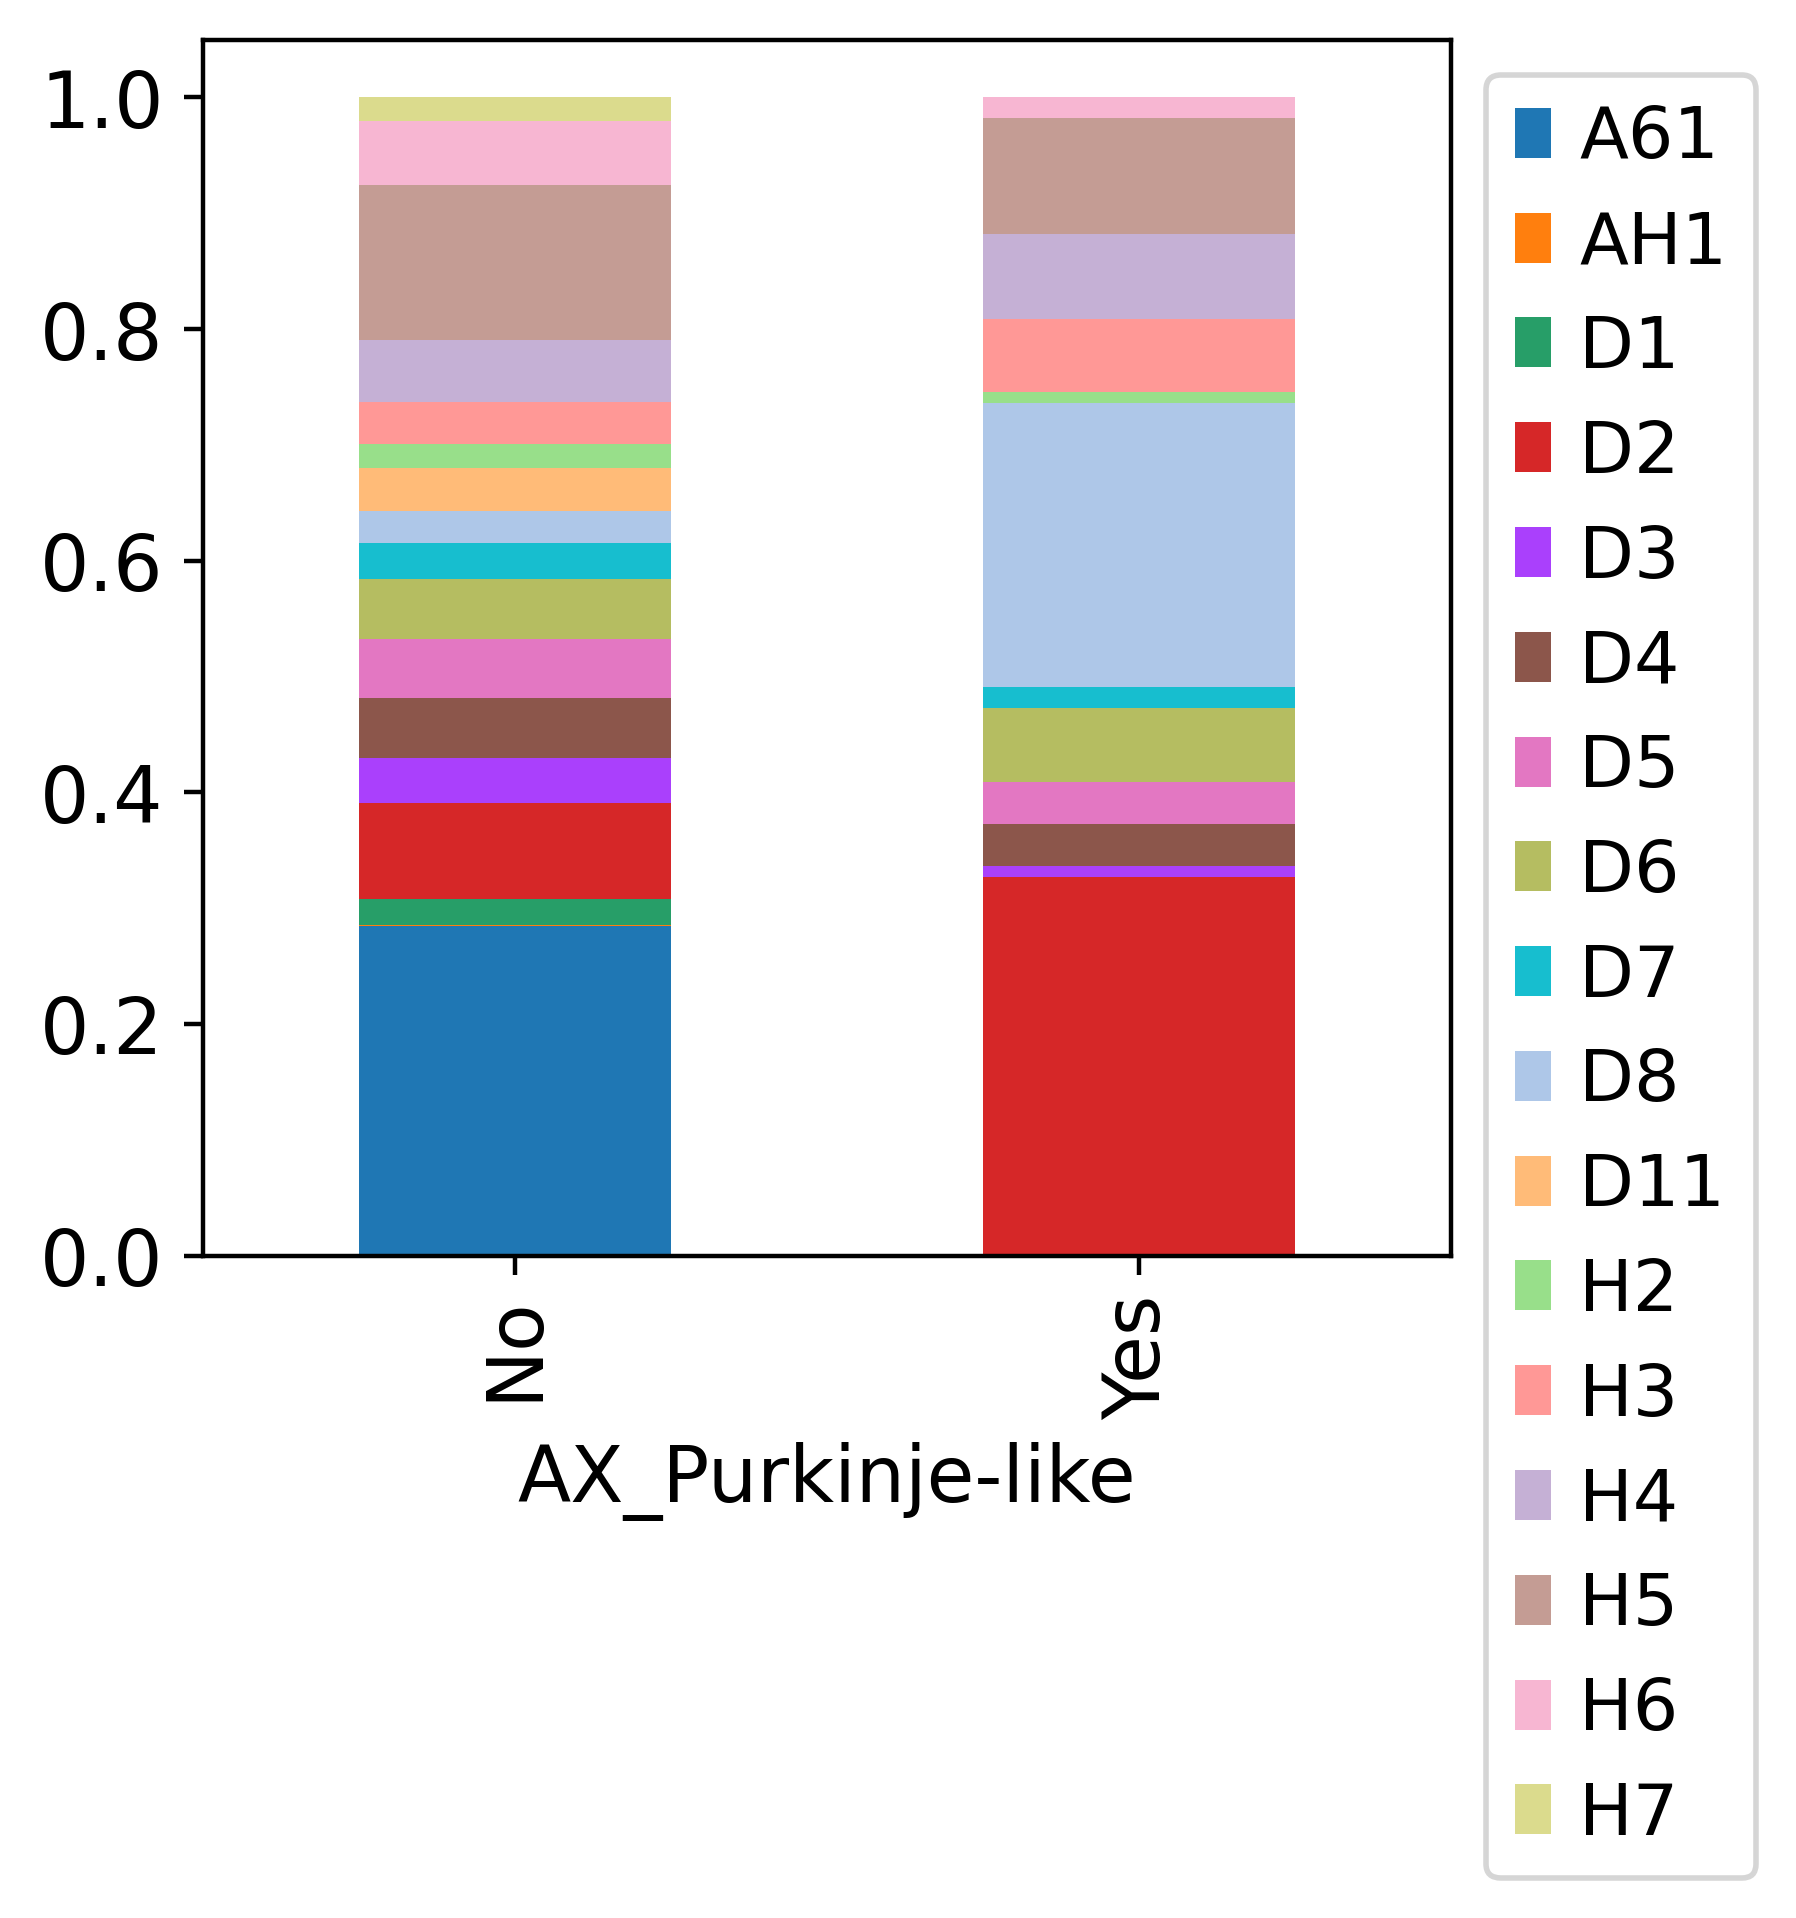

In [24]:
tmp = pd.crosstab(adata.obs['AX_Purkinje-like'], adata.obs['donor'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

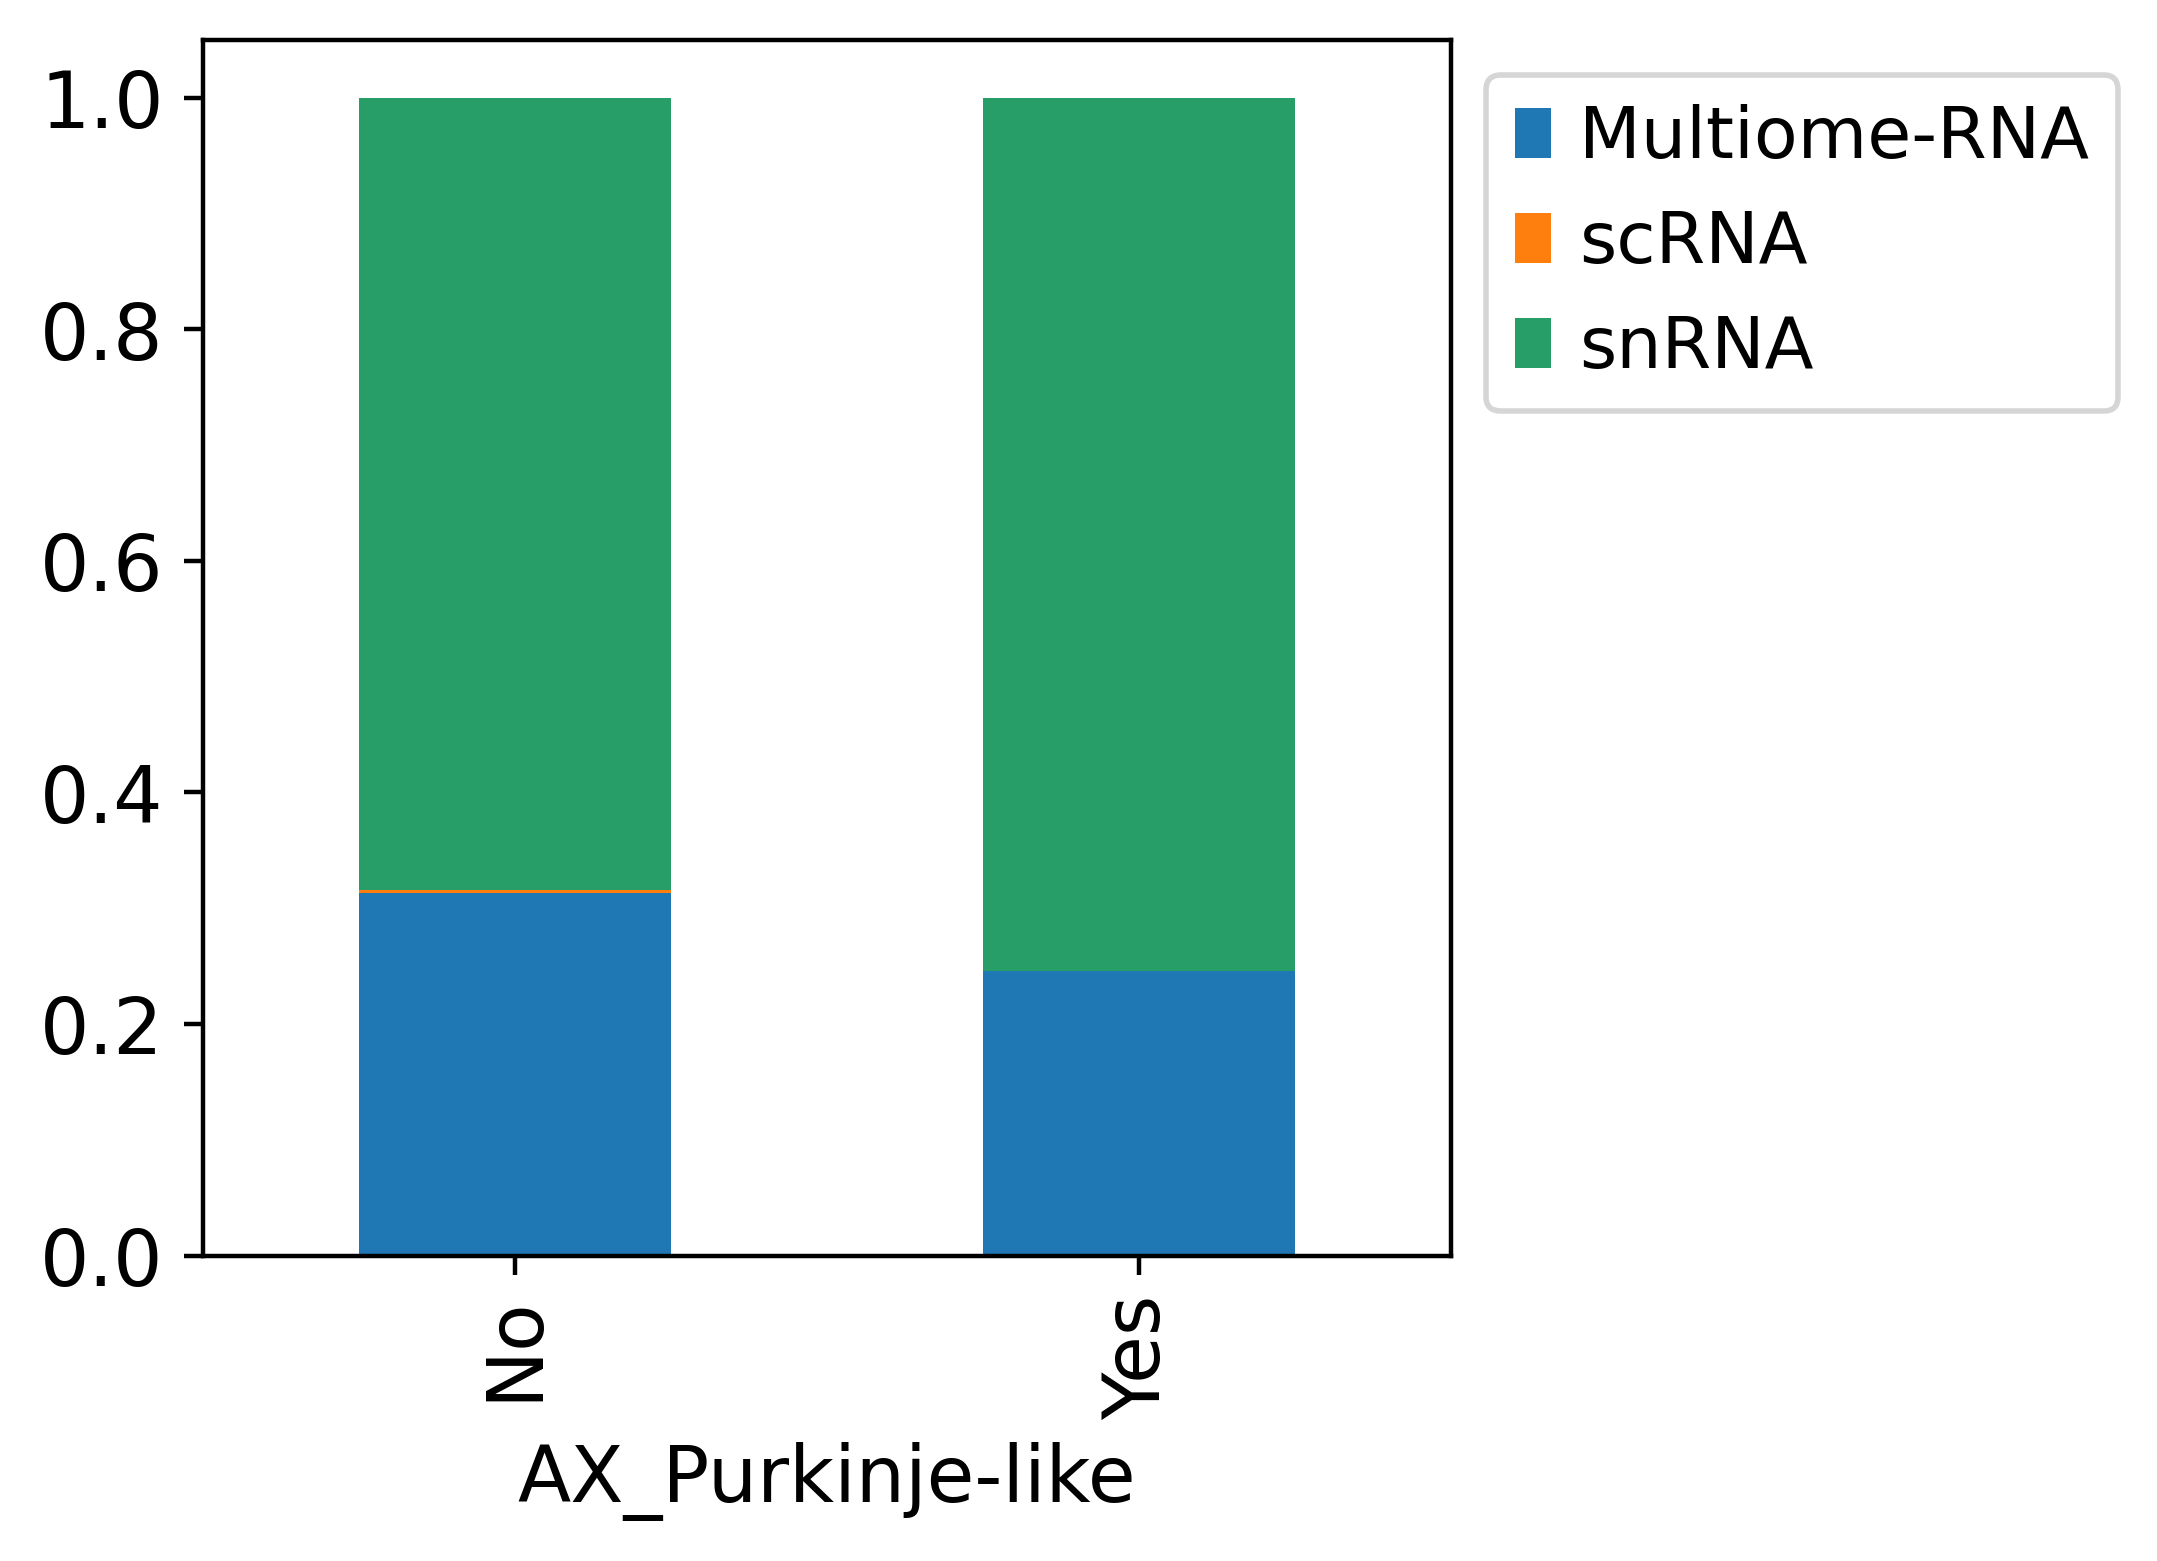

In [25]:
tmp = pd.crosstab(adata.obs['AX_Purkinje-like'], adata.obs['modality'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

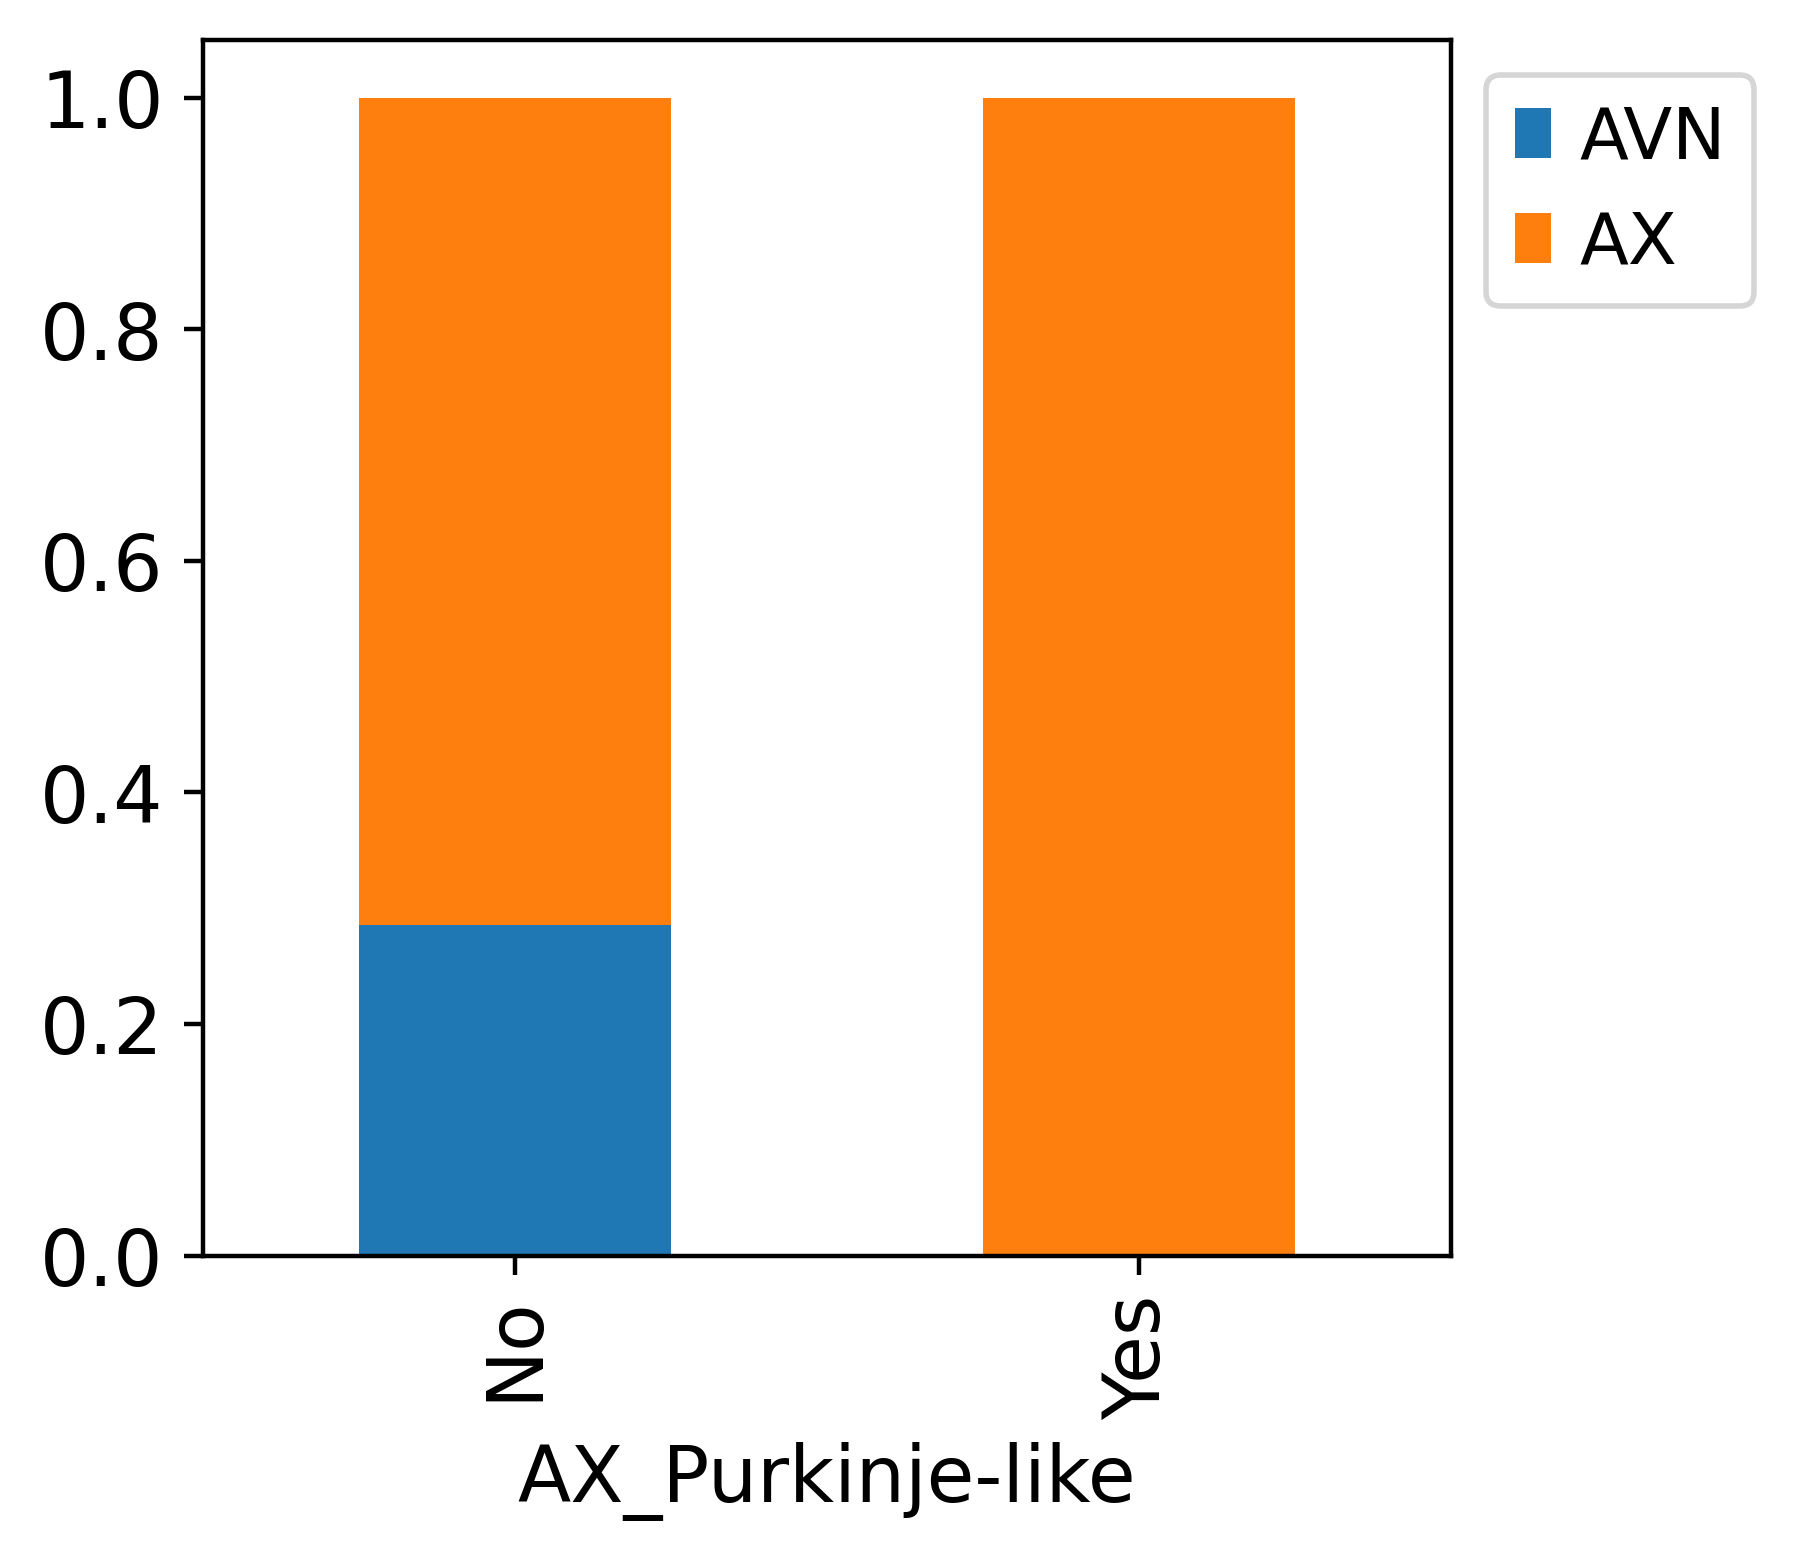

In [26]:
tmp = pd.crosstab(adata.obs['AX_Purkinje-like'], adata.obs['region'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()